In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
#dtInCU = 1000.0
#bigT = 100000
dtInCU = 2500.0
bigT = 10000

In [ ]:
bosonStar = outputProfile(massInCU, aInCU, totalMassInCU, 500)
x = bosonStar["x"]
psi = bosonStar["profile"]

dx = x[1]-x[0]
for i in range(500):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [ ]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

In [ ]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
psi = psi/normalization
psi = psi.astype(complex)

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print("DT:", dt)
print("DX:", dx)

In [ ]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [ ]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = (4.0/3.0-5.0/2.0)*3
            T[i][i+1] = (4.0/3.0-1.0/12.0)*3
            T[i][i+2] = (-1.0/12.0)*3
        elif i==1:
            T[i][i-1] = (-1.0/12.0+4.0/3.0)*3
            T[i][i] = (-5.0/2.0)*3
            T[i][i+1] = (4.0/3.0)*3
            T[i][i+2] = (-1.0/12.0)*3
        elif i==size-1:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0+4.0/3.0-1.0/12.0
            #TSph[i][i-1] = -1.0/2.0/x[i]
            #TSph[i][i] = 1.0/2.0/x[i]
            TSph[i][i-2] = 1.0/12.0/x[i]
            TSph[i][i-1] = -2.0/3.0/x[i]
            TSph[i][i] = (2.0/3.0 - 1.0/12.0)/x[i]
        elif i==size-2:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0-1.0/12.0
            #TSph[i][i+1] = 1.0/2.0/x[i]
            #TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i-2] = 1.0/12.0/x[i]
            TSph[i][i-1] = -2.0/3.0/x[i]
            TSph[i][i+1] = (2.0/3.0 - 1.0/12.0)/x[i]
        else:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            #TSph[i][i+1] = 1.0/2.0/x[i]
            #TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i-2] = 1.0/12.0/x[i]
            TSph[i][i-1] = -2.0/3.0/x[i]
            TSph[i][i+1] = 2.0/3.0/x[i]
            TSph[i][i+2] = -1.0/12.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)*np.absolute(psi)
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi))
    my_func.findGravRho(rho_c, phi_c, c_int(size), c_double(dx))
    for i in range(size):
        phi[i] = phi_c[i] * GM

    for i in range(size):
        V2Grav[i][i] = phi[i]

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

In [ ]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()

#Record
hello = []
hello2 = []
gravitationalForce = []
pressureGradient = []
quantumPressure = []

ts = []
oldGM = GM
newGM = GM*1.2
for t in range(bigT):
    #Pertubation
    if(t*dt<6.0):
        GM = newGM
    if(t*dt>=6.0):
        GM = oldGM

    setupT()
    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
    #if(normalization >= 1.01):
    #    break
    print(t, t*dt, np.absolute(psi[0]), normalization)
    if(GM == oldGM):

        #Record
        rho0 = (np.absolute(psi[14])*np.absolute(psi[14]))/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[15])*np.absolute(psi[15]))/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[16])*np.absolute(psi[16]))/Ra/Ra/Ra*totalMass
        rho3 = (np.absolute(psi[17])*np.absolute(psi[17]))/Ra/Ra/Ra*totalMass
        Q0 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[15]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho1)/2.0/m
        Q1 = -((np.sqrt(rho1) -2*np.sqrt(rho2) + np.sqrt(rho3))/(dx*Ra)/(dx*Ra) + 2.0/(x[16]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho2)/2.0/m

        gravitationalForce.append((phi[16]-phi[15])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho2-rho1)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

        def findMass():
            for i in range(size):
                if(i != 0):
                    temp = scipy.integrate.simpson(4.0*np.pi*x[:i]*x[:i]*np.absolute(psi[:i])*np.absolute(psi[:i]), x=x[:i])
                    if(temp > 0.99):
                        return i
            return size-1
            
        hello2.append(findMass())

        hello.append(np.absolute(psi[0])*np.absolute(psi[0]))
        ts.append(t*dt)

    if t%100 == 0:
        '''
        hBarInCU = 1.1977151493389159e-76
        setupV2Grav()
        np.set_printoptions(threshold=np.inf)

        rhoTemp = np.absolute(psi)*np.absolute(psi)/Ra/Ra/Ra*totalMass*5.1550e96*0.001*1.619e-18
        pressure = 2.0*np.pi*aInCU*hBarInCU*hBarInCU/massInCU/massInCU/massInCU*rhoTemp*rhoTemp
        pressureGradients = np.gradient(pressure, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        gravitationalPotential = phi*Ra*Ra*omegaA*omegaA*1.616e-35*100*6.77193e-6*1.616e-35*100*6.77193e-6/5.391e-44/5.391e-44/2.03017e5/2.03017e5

        dRhodx = np.gradient(np.sqrt(rhoTemp), x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        d2Rhodx = np.gradient(dRhodx, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)

        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradients/rhoTemp)
        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(gravitationalPotential, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2))
        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(quantumPotential, x*Ra*1.616e-35*100*6.77193e-6)/massInCU)

        plt.xlim(0.0,10000.0)
        plt.ylim(-3e-8,3e-8)
        #print(np.gradient(quantumPotential[100:1500], x[100:1500]*Ra*1.616e-35*100*6.77193e-6)/massInCU)
        #print(x[100]*Ra*1.616e-35*100*6.77193e-6)
        plt.show()
        '''

        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

In [ ]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

In [ ]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100.0)
plt.xlabel("f (1/s)")

In [ ]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.04 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

In [ ]:
plt.plot(ts, hello2)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"R99")
plt.show()

In [ ]:
sp = np.fft.fft(hello2)
freq = np.fft.fftfreq(len(hello2), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

In [ ]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 5000 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

In [ ]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

/home/kklee/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kklee/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


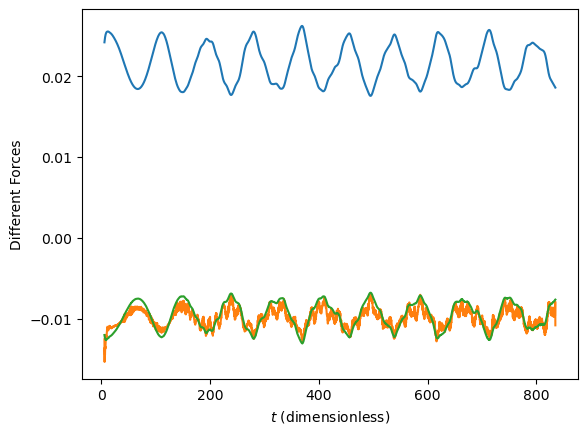

In [16]:
'''
sp = np.fft.fft(quantumPressure)
freq = np.fft.fftfreq(len(quantumPressure), d=dt)*omegaA/5.391247e-44

for i in range(len(freq)):
    if(freq[i]<=-10.0 or freq[i]>=10.0):
        sp[i] = 0.0

quantumPressure = np.fft.ifft(sp)
'''

plt.plot(ts, gravitationalForce)
plt.plot(ts, quantumPressure)
plt.plot(ts, pressureGradient)
#plt.plot(ts, gravitationalForce+pressureGradient)
#plt.plot(ts, gravitationalForce+quantumPressure)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"Different Forces")
plt.show()

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?